In [1]:
from kan import *
import pytz
import time
import datetime
from data_process import data_process_without_norm
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import copy
import pandas as pd

df = data_process_without_norm()
df = df.drop("entsoe",axis=1)
loc_tz = pytz.timezone('Europe/Zurich')
split_date_train_ = loc_tz.localize(datetime.datetime(2016,1,1,0,0,0,0))
split_date_train = loc_tz.localize(datetime.datetime(2016,3,1,0,0,0,0))
split_date_test = loc_tz.localize(datetime.datetime(2016,3,15,0,0,0,0))

df_train_ = df.loc[(split_date_train_ < df.index)]
df_train = df_train_.loc[df_train_.index <= split_date_train].copy()
_temp_df = df.loc[split_date_test > df.index]
df_test = _temp_df.loc[_temp_df.index > split_date_train].copy()

# Input standardization
scaler_input = StandardScaler()
# scaler_input = MinMaxScalerr()
_temp_scaled_input_data = scaler_input.fit_transform(df_train.iloc[:,1:])
x_train_input = _temp_scaled_input_data

#Output standardization
scaler_output = StandardScaler()
# scaler_input = MinMaxScaler()
_temp_scaled_output_data = scaler_output.fit_transform(np.array(df_train.iloc[:,0]).reshape(-1,1))
x_train_label = _temp_scaled_output_data

#Test set standardization
x_test_input = scaler_input.transform(df_test.iloc[:,1:])
x_test_label = scaler_output.transform(np.array(df_test.iloc[:,0]).reshape(-1,1))

_temp_test_input = np.hstack((x_test_input[:,:8],x_test_input[:,-3:-1]))
_temp_test_label = x_test_label
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

_temp_train_input = np.hstack((x_train_input[:, :8], x_train_input[:, -3:-1]))
_temp_train_label = x_train_label

# 将数据转换为 PyTorch 张量
train_input_tensor = torch.tensor(_temp_train_input.astype(np.float32))
train_label_tensor = torch.tensor(_temp_train_label.astype(np.float32))

test_input_tensor = torch.tensor(_temp_test_input.astype(np.float32))
test_label_tensor = torch.tensor(_temp_test_label.astype(np.float32))


In [2]:
# Find the best configuration
results_df = pd.read_csv('./parameters_configuration/KAN_BaseConfig_SPRING.csv',index_col=0).to_numpy()
best_config = results_df[results_df[:,-1].argmin(),:]

Best_step = best_config[0].astype(int)
Best_lr = best_config[1]
Best_grid = best_config[2].astype(int)
Best_k = best_config[3].astype(int)
Best_internal_units = best_config[4].astype(int)
Best_batch = best_config[5].astype(int)
Best_lamb = best_config[6].astype(float)
Best_lamb_entropy = best_config[7].astype(float)

print("\nBest Configuration: Step: {}, Learning Rate: {}, Grid: {}, K: {}, Internal Units: {}, Batch Size: {}, Lamb: {}, Lamb Entropy: {}".format(Best_step, Best_lr, Best_grid, Best_k, Best_internal_units, Best_batch, Best_lamb, Best_lamb_entropy))


Best Configuration: Step: 100, Learning Rate: 0.01, Grid: 12, K: 3, Internal Units: 16, Batch Size: 64, Lamb: 0.01, Lamb Entropy: 10.0


In [3]:
model = KAN(width=[10, int(Best_internal_units), 1], grid=Best_grid, k=Best_k, auto_save=False, seed=0, device=device)
dataset = dict()
dataset['train_input'] = torch.tensor(_temp_train_input.astype(np.float32))
dataset['train_label'] = torch.tensor(_temp_train_label.astype(np.float32))

dataset['test_input'] = torch.tensor(_temp_test_input.astype(np.float32))
dataset['test_label'] = torch.tensor(_temp_test_label.astype(np.float32))

for i in range(Best_internal_units):
    model.fix_symbolic(0, 9, i, 'sin', fit_params_bool=False)
    model.fix_symbolic(0, 8, i, 'sin', fit_params_bool=False)
        
# model.auto_save = True
# model.fit(dataset, opt="LBFGS", steps=Best_step, batch=Best_batch, lr=Best_lr, lamb=Best_lamb, lamb_entropy=Best_lamb_entropy);
model.fit(dataset, opt="Adam", steps=Best_step, batch=Best_batch, lr=Best_lr, lamb=Best_lamb, lamb_entropy=Best_lamb_entropy);

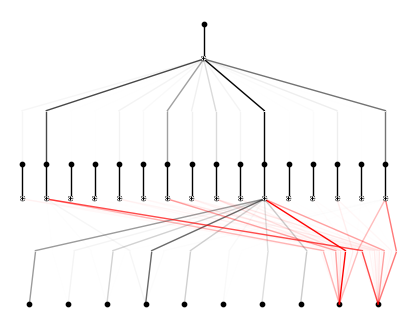

In [4]:
model.plot()

In [5]:
# Find the best configuration
results_df = pd.read_csv('./parameters_configuration/NN+KAN-SPIRNG.csv',index_col=0).to_numpy()
best_config = results_df[results_df[:,-1].argmin(),:]
Best_threshold_1 = best_config[0]
Best_threshold_2 = best_config[1]
print("\nBest Configuration: Best_threshold_1: {}, Best_threshold_2: {}".format(Best_threshold_1, Best_threshold_2))


Best Configuration: Best_threshold_1: 0.02, Best_threshold_2: 0.03


saving model version 0.1


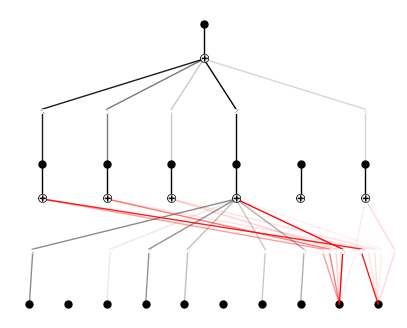

In [6]:
model = model.prune(node_th=Best_threshold_1, edge_th=Best_threshold_2);
model.auto_save = True
model.fit(dataset, opt="Adam", steps=Best_step, batch=Best_batch, lr=Best_lr, lamb=Best_lamb, lamb_entropy=Best_lamb_entropy);
model.plot()

In [7]:
# source conde prune_input return input_mask
model,input_mask = model.prune_input()
# model.edge_scores
# model.node_scores

keep: [True, False, True, True, True, False, True, True, True, True]
saving model version 0.2


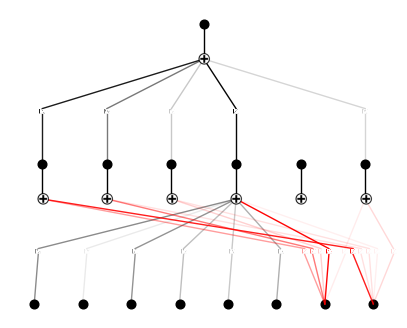

In [8]:
model.plot()

In [9]:
lib = ['x','x^2','exp','sqrt','tanh','sin','arctanh']
model.auto_symbolic(lib=lib)
# model.symbolic_formula()

fixing (0,0,0) with 0
fixing (0,0,1) with 0
fixing (0,0,2) with 0
fixing (0,0,3) with x, r2=0.6218512654304504, c=1
fixing (0,0,4) with 0
fixing (0,0,5) with 0
fixing (0,1,0) with 0
fixing (0,1,1) with 0
fixing (0,1,2) with 0
fixing (0,1,3) with x, r2=0.22308853268623352, c=1
fixing (0,1,4) with 0
fixing (0,1,5) with 0
fixing (0,2,0) with 0
fixing (0,2,1) with 0
fixing (0,2,2) with 0
fixing (0,2,3) with x, r2=0.8910674452781677, c=1
fixing (0,2,4) with 0
fixing (0,2,5) with 0
fixing (0,3,0) with 0
fixing (0,3,1) with 0
fixing (0,3,2) with 0
fixing (0,3,3) with x, r2=0.5167895555496216, c=1
fixing (0,3,4) with 0
fixing (0,3,5) with 0
fixing (0,4,0) with 0
fixing (0,4,1) with 0
fixing (0,4,2) with 0
fixing (0,4,3) with x, r2=0.27104657888412476, c=1
fixing (0,4,4) with 0
fixing (0,4,5) with 0
fixing (0,5,0) with 0
fixing (0,5,1) with 0
fixing (0,5,2) with 0
fixing (0,5,3) with x, r2=0.40133213996887207, c=1
fixing (0,5,4) with 0
fixing (0,5,5) with 0
skipping (0,6,0) since already symbol

In [10]:
# def revise_dataset(dataset,input_index):
#     dataset['train_input'] = dataset['train_input'][:,input_index]
#     dataset['test_input'] = dataset['test_input'][:,input_index]
#     return dataset
# true_indices = np.where(input_mask.detach().numpy())[0]
# dataset = revise_dataset(dataset,true_indices)
model.fit(dataset, opt="Adam", steps=Best_step, batch=Best_batch, lr=Best_lr);

saving model version 0.4


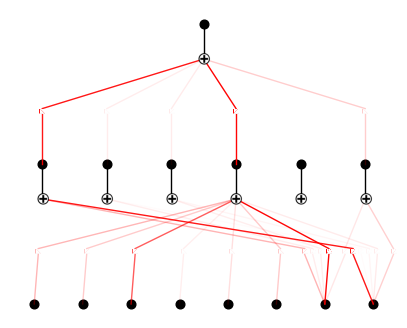

In [11]:
model.plot()

In [12]:
model.symbolic_formula()

([-0.157692997029526*x_1 + 0.113850113940205*x_2 + 0.245398832251325*x_3 - 0.0375700709960873*x_4 - 0.0743275047585727*x_5 - 0.116481679000977*x_6 - 0.204698512949699*sin(0.447511345148087*x_7 + 0.0286507196724415) - 0.0591604042364544*sin(0.499916136264801*x_7 - 0.1096510887146) + 0.0265937246139742*sin(0.98316103219986*x_7 - 0.023726150393486) + 0.937441504029815*sin(1.53568255901337*x_7 + 0.966745615005493) - 0.0301989758231221*sin(1.76254463195801*x_7 + 0.0300564803183079) + 0.130277511623152*sin(0.231478303670883*x_8 + 0.642546415328979) - 0.0100944301607952*sin(0.554427683353424*x_8 - 0.148667931556702) - 0.0930141061618751*sin(0.937524080276489*x_8 - 0.636243104934692) - 0.683908913102481*sin(1.11288797855377*x_8 - 0.608056306838989) + 0.0159048023483007*sin(1.70630741119385*x_8 + 0.206274792551994) - 0.452060809916076],
 [x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8])

In [13]:
def RMSE(_pre,_actual):
    MSE = ((_pre-_actual)**2)/15/24   
    return np.sqrt(MSE.sum())
    
def MAE(_pre,_actual):
    return (np.abs((_pre-_actual))).sum()/15/24
    
def MAPE(_pre,_actual):
    return ((np.abs((_pre-_actual)))/_actual).sum()/15/24
    
def evaluation(_pre,_actual): 
    return [RMSE(_pre,_actual),MAE(_pre,_actual),MAPE(_pre,_actual)]

In [14]:
pre_KAN = model.forward(dataset['test_input']).detach().numpy()

actual = scaler_output.inverse_transform(dataset['test_label'].reshape(-1,1))

pre_KAN_ = scaler_output.inverse_transform(pre_KAN)

result = dict()
result["KAN-Spring-base"] = evaluation(pre_KAN_,actual)

In [15]:
split_date_train_ = loc_tz.localize(datetime.datetime(2016,4,1,0,0,0,0))
split_date_train = loc_tz.localize(datetime.datetime(2016,6,1,0,0,0,0))
split_date_test = loc_tz.localize(datetime.datetime(2016,6,15,0,0,0,0))

df_train_ = df.loc[(split_date_train_ < df.index)]
df_train = df_train_.loc[df_train_.index <= split_date_train].copy()
_temp_df = df.loc[split_date_test > df.index]
df_test = _temp_df.loc[_temp_df.index > split_date_train].copy()

# Input standardization
scaler_input = StandardScaler()
# scaler_input = MinMaxScalerr()
_temp_scaled_input_data = scaler_input.fit_transform(df_train.iloc[:,1:])
x_train_input = _temp_scaled_input_data

#Output standardization
scaler_output = StandardScaler()
# scaler_input = MinMaxScaler()
_temp_scaled_output_data = scaler_output.fit_transform(np.array(df_train.iloc[:,0]).reshape(-1,1))
x_train_label = _temp_scaled_output_data

#Test set standardization
x_test_input = scaler_input.transform(df_test.iloc[:,1:])
x_test_label = scaler_output.transform(np.array(df_test.iloc[:,0]).reshape(-1,1))

_temp_test_input = np.hstack((x_test_input[:,:8],x_test_input[:,-3:-1]))
_temp_test_label = x_test_label
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

_temp_train_input = np.hstack((x_train_input[:, :8], x_train_input[:, -3:-1]))
_temp_train_label = x_train_label

# 将数据转换为 PyTorch 张量
train_input_tensor = torch.tensor(_temp_train_input.astype(np.float32))
train_label_tensor = torch.tensor(_temp_train_label.astype(np.float32))

test_input_tensor = torch.tensor(_temp_test_input.astype(np.float32))
test_label_tensor = torch.tensor(_temp_test_label.astype(np.float32))

dataset = dict()
dataset['train_input'] = torch.tensor(_temp_train_input.astype(np.float32))
dataset['train_label'] = torch.tensor(_temp_train_label.astype(np.float32))

dataset['test_input'] = torch.tensor(_temp_test_input.astype(np.float32))
dataset['test_label'] = torch.tensor(_temp_test_label.astype(np.float32))

import torch.nn as nn
import torch.optim as optim

# FCN2 模型
class FCN2(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_units1=32, hidden_units2=16):
        super(FCN2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(num_inputs, hidden_units1),
            nn.ReLU(),
            nn.Linear(hidden_units1, hidden_units2),
            nn.ReLU(),
            nn.Linear(hidden_units2, num_outputs)
        )

    def forward(self, x):
        return self.net(x)

# KAN_ADD_NN 类
class KAN_ADD_NN(nn.Module):
    def __init__(self, module1, module2, rho=10.0, mu=0.1):
        super(KAN_ADD_NN, self).__init__()
        self.module1 = module1  # Neural network for f(x, theta1)
        self.module2 = module2  # Neural network for g(x, theta2)
        self.fc1 = nn.Linear(2, 1)  # Linear layer to combine outputs of module1 and module2
        self.rho = rho  # Penalty parameter for ADMM
        self.mu = mu  # Constraint parameter ||w2|| < mu
        self.z = torch.zeros_like(self.fc1.weight[:, 1], requires_grad=False)  # Auxiliary variable z
        self.u = torch.zeros_like(self.fc1.weight[:, 1], requires_grad=False)  # Dual variable u

    def forward(self, x1, x2):
        y1 = self.module1(x1)
        y2 = self.module2(x2)
        y = self.fc1(torch.cat((y1, y2), 1))
        return y

    def loss_func(self, x1, x2, y_actual):
        y_pre = self.forward(x1, x2)
        loss = torch.mean((y_pre - y_actual) ** 2)
        return loss

    def update_z(self):
        with torch.no_grad():
            w2 = self.fc1.weight[:, 1]
            self.z = torch.clamp(w2 + self.u / self.rho, max=self.mu)

    def update_u(self):
        with torch.no_grad():
            w2 = self.fc1.weight[:, 1]
            self.u += self.rho * (w2 - self.z)

    def admm_step(self, x1, x2, y_actual, optimizer):
        optimizer.zero_grad()
        loss = self.loss_func(x1, x2, y_actual)
        loss.backward()
        optimizer.step()
        self.update_z()
        self.update_u()

# 分割数据
train_input_fold = train_input_tensor
train_label_fold = train_label_tensor
val_input_fold = train_input_tensor
val_label_fold = train_label_tensor

# 创建数据加载器
train_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(train_input_fold.clone().detach(),train_input_fold.clone().detach(), train_label_fold.clone().detach()),
    batch_size=64,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(val_input_fold.clone().detach(),val_input_fold.clone().detach(), val_label_fold.clone().detach()),
    batch_size=64,
    shuffle=False
)

# 确保第一个模型是 KAN_model
model_ADD = KAN_ADD_NN(model.copy(),FCN2(10, 1, 32))
optimizer = optim.Adam(model_ADD.parameters(), lr=0.01)

# 训练模型
start_time = time.time()
for epoch in range(50):
    model_ADD.train()
    for x, y, z in train_loader:
        model_ADD.admm_step(x, y, z, optimizer)  # 使用可能不相同的输入 x 和 y

actual = scaler_output.inverse_transform(dataset['test_label'].reshape(-1,1))
pre_KAN = model_ADD.forward(dataset['test_input'],dataset['test_input']).detach().numpy()
pre_KAN_ = scaler_output.inverse_transform(pre_KAN)
result["KAN-Summer-transfer"] = evaluation(pre_KAN_,actual)

In [16]:
split_date_train_ = loc_tz.localize(datetime.datetime(2016,7,1,0,0,0,0))
split_date_train = loc_tz.localize(datetime.datetime(2016,9,1,0,0,0,0))
split_date_test = loc_tz.localize(datetime.datetime(2016,9,15,0,0,0,0))

df_train_ = df.loc[(split_date_train_ < df.index)]
df_train = df_train_.loc[df_train_.index <= split_date_train].copy()
_temp_df = df.loc[split_date_test > df.index]
df_test = _temp_df.loc[_temp_df.index > split_date_train].copy()

# Input standardization
scaler_input = StandardScaler()
# scaler_input = MinMaxScalerr()
_temp_scaled_input_data = scaler_input.fit_transform(df_train.iloc[:,1:])
x_train_input = _temp_scaled_input_data

#Output standardization
scaler_output = StandardScaler()
# scaler_input = MinMaxScaler()
_temp_scaled_output_data = scaler_output.fit_transform(np.array(df_train.iloc[:,0]).reshape(-1,1))
x_train_label = _temp_scaled_output_data

#Test set standardization
x_test_input = scaler_input.transform(df_test.iloc[:,1:])
x_test_label = scaler_output.transform(np.array(df_test.iloc[:,0]).reshape(-1,1))

_temp_test_input = np.hstack((x_test_input[:,:8],x_test_input[:,-3:-1]))
_temp_test_label = x_test_label
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

_temp_train_input = np.hstack((x_train_input[:, :8], x_train_input[:, -3:-1]))
_temp_train_label = x_train_label

# 将数据转换为 PyTorch 张量
train_input_tensor = torch.tensor(_temp_train_input.astype(np.float32))
train_label_tensor = torch.tensor(_temp_train_label.astype(np.float32))

test_input_tensor = torch.tensor(_temp_test_input.astype(np.float32))
test_label_tensor = torch.tensor(_temp_test_label.astype(np.float32))

dataset = dict()
dataset['train_input'] = torch.tensor(_temp_train_input.astype(np.float32))
dataset['train_label'] = torch.tensor(_temp_train_label.astype(np.float32))

dataset['test_input'] = torch.tensor(_temp_test_input.astype(np.float32))
dataset['test_label'] = torch.tensor(_temp_test_label.astype(np.float32))

# 分割数据
train_input_fold = train_input_tensor
train_label_fold = train_label_tensor
val_input_fold = train_input_tensor
val_label_fold = train_label_tensor

# 创建数据加载器
train_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(train_input_fold.clone().detach(),train_input_fold.clone().detach(), train_label_fold.clone().detach()),
    batch_size=64,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(val_input_fold.clone().detach(),val_input_fold.clone().detach(), val_label_fold.clone().detach()),
    batch_size=64,
    shuffle=False
)

# 确保第一个模型是 KAN_model
model_ADD = KAN_ADD_NN(model.copy(),FCN2(10, 1, 32))
optimizer = optim.Adam(model_ADD.parameters(), lr=0.01)

# 训练模型
start_time = time.time()
for epoch in range(50):
    model_ADD.train()
    for x, y, z in train_loader:
        model_ADD.admm_step(x, y, z, optimizer)  # 使用可能不相同的输入 x 和 y

actual = scaler_output.inverse_transform(dataset['test_label'].reshape(-1,1))
pre_KAN = model_ADD.forward(dataset['test_input'],dataset['test_input']).detach().numpy()
pre_KAN_ = scaler_output.inverse_transform(pre_KAN)
result["KAN-Autumn-transfer"] = evaluation(pre_KAN_,actual)

In [17]:
split_date_train_ = loc_tz.localize(datetime.datetime(2016,10,1,0,0,0,0))
split_date_train = loc_tz.localize(datetime.datetime(2016,12,1,0,0,0,0))
split_date_test = loc_tz.localize(datetime.datetime(2016,12,15,0,0,0,0))

df_train_ = df.loc[(split_date_train_ < df.index)]
df_train = df_train_.loc[df_train_.index <= split_date_train].copy()
_temp_df = df.loc[split_date_test > df.index]
df_test = _temp_df.loc[_temp_df.index > split_date_train].copy()

# Input standardization
scaler_input = StandardScaler()
# scaler_input = MinMaxScalerr()
_temp_scaled_input_data = scaler_input.fit_transform(df_train.iloc[:,1:])
x_train_input = _temp_scaled_input_data

#Output standardization
scaler_output = StandardScaler()
# scaler_input = MinMaxScaler()
_temp_scaled_output_data = scaler_output.fit_transform(np.array(df_train.iloc[:,0]).reshape(-1,1))
x_train_label = _temp_scaled_output_data

#Test set standardization
x_test_input = scaler_input.transform(df_test.iloc[:,1:])
x_test_label = scaler_output.transform(np.array(df_test.iloc[:,0]).reshape(-1,1))

_temp_test_input = np.hstack((x_test_input[:,:8],x_test_input[:,-3:-1]))
_temp_test_label = x_test_label
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

_temp_train_input = np.hstack((x_train_input[:, :8], x_train_input[:, -3:-1]))
_temp_train_label = x_train_label

# 将数据转换为 PyTorch 张量
train_input_tensor = torch.tensor(_temp_train_input.astype(np.float32))
train_label_tensor = torch.tensor(_temp_train_label.astype(np.float32))

test_input_tensor = torch.tensor(_temp_test_input.astype(np.float32))
test_label_tensor = torch.tensor(_temp_test_label.astype(np.float32))

dataset = dict()
dataset['train_input'] = torch.tensor(_temp_train_input.astype(np.float32))
dataset['train_label'] = torch.tensor(_temp_train_label.astype(np.float32))

dataset['test_input'] = torch.tensor(_temp_test_input.astype(np.float32))
dataset['test_label'] = torch.tensor(_temp_test_label.astype(np.float32))

# 分割数据
train_input_fold = train_input_tensor
train_label_fold = train_label_tensor
val_input_fold = train_input_tensor
val_label_fold = train_label_tensor

# 创建数据加载器
train_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(train_input_fold.clone().detach(),train_input_fold.clone().detach(), train_label_fold.clone().detach()),
    batch_size=64,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(val_input_fold.clone().detach(),val_input_fold.clone().detach(), val_label_fold.clone().detach()),
    batch_size=64,
    shuffle=False
)

# 确保第一个模型是 KAN_model
model_ADD = KAN_ADD_NN(model.copy(),FCN2(10, 1, 32))
optimizer = optim.Adam(model_ADD.parameters(), lr=0.001)

# 训练模型
start_time = time.time()
for epoch in range(50):
    model_ADD.train()
    for x, y, z in train_loader:
        model_ADD.admm_step(x, y, z, optimizer)  # 使用可能不相同的输入 x 和 y

actual = scaler_output.inverse_transform(dataset['test_label'].reshape(-1,1))
pre_KAN = model_ADD.forward(dataset['test_input'],dataset['test_input']).detach().numpy()
pre_KAN_ = scaler_output.inverse_transform(pre_KAN)
result["KAN-Winter-transfer"] = evaluation(pre_KAN_,actual)

In [18]:
result

{'KAN-Spring-base': [442.20922703862385,
  351.72743708702245,
  0.04574528704168695],
 'KAN-Summer-transfer': [362.59090026605907,
  286.5389672414495,
  0.045862236817649525],
 'KAN-Autumn-transfer': [334.2511070806518,
  243.12849013483194,
  0.03755543483729019],
 'KAN-Winter-transfer': [521.3756445613828,
  406.75077749812675,
  0.05232811825993967]}